In [29]:
## Solve Every Sudoku Puzzle

## See http://norvig.com/sudoku.html

## Throughout this program we have:
##   r is a row,    e.g. 'A'
##   c is a column, e.g. '3'
##   s is a square, e.g. 'A3'
##   d is a digit,  e.g. '9'
##   u is a unit,   e.g. ['A1','B1','C1','D1','E1','F1','G1','H1','I1']
##   grid is a grid,e.g. 81 non-blank chars, e.g. starting with '.18...7...
##   values is a dict of possible values, e.g. {'A1':'12349', 'A2':'8', ...}

# Generate all the suquares with the name of the row and the column
def cross(A, B):
    "Cross product of elements in A and elements in B."
    return [a+b for a in A for b in B]

digits   = '123456789'
rows     = 'ABCDEFGHI'
cols     = digits
squares  = cross(rows, cols)
unitlist = ([cross(rows, c) for c in cols] +
            [cross(r, cols) for r in rows] +
            [cross(rs, cs) for rs in ('ABC','DEF','GHI') for cs in ('123','456','789')])
units = dict((s, [u for u in unitlist if s in u])
             for s in squares)
peers = dict((s, set(sum(units[s],[]))-set([s]))
             for s in squares)

def test():
    "A set of tests that must pass."
    assert len(squares) == 81
    assert len(unitlist) == 27
    assert all(len(units[s]) == 3 for s in squares)
    assert all(len(peers[s]) == 20 for s in squares)
    assert units['C2'] == [['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'H2', 'I2'],
                           ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9'],
                           ['A1', 'A2', 'A3', 'B1', 'B2', 'B3', 'C1', 'C2', 'C3']]
    assert peers['C2'] == set(['A2', 'B2', 'D2', 'E2', 'F2', 'G2', 'H2', 'I2',
                               'C1', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9',
                               'A1', 'A3', 'B1', 'B3'])
    print ('All tests pass.')
    
     # parse a grid into a values dict:

def parse_grid(grid):
    """Convert grid to a dict of possible values, {square: digits}, or
    return False if a contradiction is detected."""
    ## To start, every square can be any digit; then assign values from the grid.
    values = dict((s, digits) for s in squares)
    for s,d in grid_values(grid).items():
        if d in digits and not assign(values, s, d):
            return False ## (Fail if we can't assign d to square s.)
    return values

def grid_values(grid):
    "Convert grid into a dict of {square: char} with '0' or '.' for empties."
    chars = [c for c in grid if c in digits or c in '0.']
    assert len(chars) == 81
    return dict(zip(squares, chars))

# Constraint Propagation
def assign(values, s, d):
    """Eliminate all the other values (except d) from values[s] and propagate.
    Return values, except return False if a contradiction is detected."""
    other_values = values[s].replace(d, '')
    if all(eliminate(values, s, d2) for d2 in other_values):
        return values
    else:
        return False

def eliminate(values, s, d):
    """Eliminate d from values[s]; propagate when values or places <= 2.
    Return values, except return False if a contradiction is detected."""
    if d not in values[s]:
        return values ## Already eliminated
    values[s] = values[s].replace(d,'')
    ## (1) If a square s is reduced to one value d2, then eliminate d2 from the peers.
    if len(values[s]) == 0:
        return False ## Contradiction: removed last value
    elif len(values[s]) == 1:
        d2 = values[s]
        if not all(eliminate(values, s2, d2) for s2 in peers[s]):
            return False
    ## (2) If a unit u is reduced to only one place for a value d, then put it there.
    for u in units[s]:
        dplaces = [s for s in u if d in values[s]]
        if len(dplaces) == 0:
            return False ## Contradiction: no place for this value
        elif len(dplaces) == 1:
            # d can only be in one place in unit; assign it there
            if not assign(values, dplaces[0], d):
                return False
    
    return values

def display(values):
    "Display these values as a 2-D grid."
    width = 1 + max(len(values[s]) for s in squares)
    line = '+'.join(['-' * (width * 3)] * 3)
    for r in rows:
        # use join to concatenate the strings
        print(''.join(values[r + c].center(width) + ('|' if c in '36' else '') for c in cols))
        if r in 'CF': 
            print(line)

# HiddenSingles  heuristic

In [31]:
# Constraint Propagation
def assignHiddenSingles(values, s, d):
    """Eliminate all the other values (except d) from values[s] and propagate.
    Return values, except return False if a contradiction is detected."""
    other_values = values[s].replace(d, '')
    if all(eliminateHiddenSingles(values, s, d2) for d2 in other_values):
        return values
    else:
        return False

def eliminateHiddenSingles(values, s, d):
    """Eliminate d from values[s]; propagate when values or places <= 2.
    Return values, except return False if a contradiction is detected."""
    if d not in values[s]:
        return values ## Already eliminated
    values[s] = values[s].replace(d,'')
    ## (1) If a square s is reduced to one value d2, then eliminate d2 from the peers.
    if len(values[s]) == 0:
        return False ## Contradiction: removed last value
    elif len(values[s]) == 1:
        d2 = values[s]
        if not all(eliminateHiddenSingles(values, s2, d2) for s2 in peers[s]):
            return False
    ## (2) If a unit u is reduced to only one place for a value d, then put it there.
    for u in units[s]:
        dplaces = [s for s in u if d in values[s]]
        if len(dplaces) == 0:
            return False ## Contradiction: no place for this value
        elif len(dplaces) == 1:
            # d can only be in one place in unit; assign it there
            if not assignHiddenSingles(values, dplaces[0], d):
                return False
    ## (3) there is only one candidate for a given row, column or box, but it is hidden among other candidates.
    for u in units[s]:
        for d in digits:  # digits '123456789'
            dplaces = [s for s in u if d in values[s]]
            if len(dplaces) == 1 and len(values[dplaces[0]]) > 1:
                # if d only can be in one place in unit; assign it there
                if not assignHiddenSingles(values, dplaces[0], d):
                    return False
    
    return values

The core function search is what we will work at!

### Normal Solve

In [32]:
import random, time
import matplotlib.pyplot as plt

def solve(grid): return search(parse_grid(grid))

def search(values):
    "Using depth-first search and propagation, try all possible values."
    if values is False:
        return False ## Failed earlier
    if all(len(values[s]) == 1 for s in squares):
        return values ## Solved!
    ## Chose the unfilled square s with the fewest possibilities
    n,s = min((len(values[s]), s) for s in squares if len(values[s]) > 1)
    
    # s = random.choice([s for s in squares if len(values[s]) > 1])
    return some(search(assign(values.copy(), s, d))
                for d in values[s])

def some(seq):
    "Return some element of seq that is true."
    for e in seq:
        if e: return e
    return False

### SovleHiddenSigles

In [34]:
def solveHiddenSingles(grid): return searchHiddenSingles(parse_grid(grid))

def searchHiddenSingles(values):
    "Using depth-first search and propagation, try all possible values."
    if values is False:
        return False ## Failed earlier
    if all(len(values[s]) == 1 for s in squares):
        return values ## Solved!
    ## Chose the unfilled square s with the fewest possibilities
    n,s = min((len(values[s]), s) for s in squares if len(values[s]) > 1)
    
    # s = random.choice([s for s in squares if len(values[s]) > 1])
    return some(search(assignHiddenSingles(values.copy(), s, d))
                for d in values[s])

### SloveHiddenPairs

In [35]:
def solve_Hidden_Pairs(grid): return search_Hidden_Pairs(parse_grid(grid))

def search_Hidden_Pairs(values):
    if values is False:
        return False  ## Failed earlier

    if all(len(values[s]) == 1 for s in squares):
        return values   ## Solved!


    found_values = hidden_pairs(values.copy())
    if len(found_values) == 0:  #dict vide
        return False

    #find an insolved square
    for s in squares:
        if len(found_values[s]) > 1:
            break

    return some(search(assign(found_values.copy(), s, d))for d in found_values[s])

def hidden_pairs(values):
    for unit in unitlist:
        candidature = {}
        for s in unit:
            for d in values[s]:
                candidature[d] = candidature[d] + [s] if d in candidature else [s]


        dict_hidden_pairs = {}
        for d, elem in candidature.items():
            if len(elem) == 2:
                elem_tuple = tuple(elem)  #hashable type
                dict_hidden_pairs[elem_tuple] = dict_hidden_pairs[elem_tuple] + [d] if (elem_tuple
                                                                                        in dict_hidden_pairs) else [d]

        for elem, candidates in dict_hidden_pairs.items():
            if len(candidates) == 2:
                for s in elem:
                    values[s] = ''.join(candidates)


    return values


### Locked candidates

In [46]:
def solve_Locked_candidates(grid): return search_Locked_candidates(parse_grid(grid))



def eliminate_locked_candidates(values):
    """Eliminate values using the Locked Candidates Type 1 strategy."""
    for unit in unitlist:
        for digit in '123456789':
            # 找到可能包含特定数字的所有格子
            digit_places = [square for square in unit if digit in values[square]]
            if not digit_places:
                continue
            
            # 检查是否所有这些格子都在同一行或同一列
            rows = set(square[0] for square in digit_places)
            cols = set(square[1] for square in digit_places)
            if len(rows) == 1:
                # 如果在同一行，从该行的其他宫中排除这个数字
                row_units = [cross(row, cols) for row in rows]
                for row_unit in row_units[0]:
                    if row_unit not in unit:  # 排除当前宫的格子
                        for square in row_unit:
                            if digit in values[square]:
                                values[square] = values[square].replace(digit, '')
            elif len(cols) == 1:
                # 如果在同一列，从该列的其他宫中排除这个数字
                col_units = [cross(rows, col) for col in cols]
                for col_unit in col_units[0]:
                    if col_unit not in unit:  # 排除当前宫的格子
                        for square in col_unit:
                            if digit in values[square]:
                                values[square] = values[square].replace(digit, '')

    return values

def search_Locked_candidates(values):
    "Using depth-first search and propagation, try all possible values."
    if values is False:
        return False  # 失败
    
    values = eliminate_locked_candidates(values)
    if values is False:
        return False  # 如果发现矛盾，失败
    
    if all(len(values[s]) == 1 for s in squares):
        return values  # 解决
    
    # 选择未填充的格子进行尝试
    n, s = min((len(values[s]), s) for s in squares if len(values[s]) > 1)
    return some(search(assign(values.copy(), s, d))
                for d in values[s])


### Value ordering

In [53]:
def solve_value_ordering(grid): return search_value_ordering(parse_grid(grid))

def search_value_ordering(values):
    if values is False:
        return False
    if all(len(values[s]) == 1 for s in squares):
        return values

    # 使用MRV选择格子
    _, s = min((len(values[s]), s) for s in squares if len(values[s]) > 1)

    # 获取并排序当前格子的候选数字，优先尝试出现次数最少的数字
    d_values_sorted = sorted(values[s], key=lambda d: sum(1 for unit in units[s] for u in unit if d in values[u]))

    return some(search(assign(values.copy(), s, d)) for d in d_values_sorted)


In [36]:
# Utility functions
def some(seq):
    "Return some element of seq that is true."
    for e in seq:
        if e: return e
    return False

def from_file(filename, sep='\n'):
    "Parse a file into a list of strings, separated by sep."
    return open(filename).read().strip().split(sep)

def shuffled(seq):
    "Return a randomly shuffled copy of the input sequence."
    seq = list(seq)
    random.shuffle(seq)
    return seq

def solve_all(grids, name='', showif=0.0):
    """Attempt to solve a sequence of grids. Report results.
    When showif is a number of seconds, display puzzles that take longer.
    When showif is None, don't display any puzzles."""
    def time_solve(grid):
        start = time.perf_counter()  # use time.perf_counter to replace time.clock
        values = solve(grid)  
        t = time.perf_counter() - start
        ## Display puzzles that take long enough
        if showif is not None and t > showif:
            display(grid_values(grid))
            if values: display(values)
            print ('(%.2f seconds)\n' % t)
        return (t, solved(values))
    times, results = zip(*[time_solve(grid) for grid in grids])
    N = len(grids)
    if N > 1:
        print ("Solved %d of %d %s puzzles (avg %.4f secs (%d Hz), max %.4f secs)." % (
            sum(results), N, name, sum(times)/N, N/sum(times), max(times)))

def solved(values):
    "A puzzle is solved if each unit is a permutation of the digits 1 to 9."
    def unitsolved(unit): return set(values[s] for s in unit) == set(digits)
    return values is not False and all(unitsolved(unit) for unit in unitlist)

def random_puzzle(N=17):
    """Make a random puzzle with N or more assignments. Restart on contradictions.
    Note the resulting puzzle is not guaranteed to be solvable, but empirically
    about 99.8% of them are solvable. Some have multiple solutions."""
    values = dict((s, digits) for s in squares)
    for s in shuffled(squares):
        if not assign(values, s, random.choice(values[s])):
            break
        ds = [values[s] for s in squares if len(values[s]) == 1]
        if len(ds) >= N and len(set(ds)) >= 8:
            return ''.join(values[s] if len(values[s])==1 else '.' for s in squares)
    return random_puzzle(N) ## Give up and make a new puzzle

if __name__ == '__main__':
    test()
    solve_all(from_file("top95.txt"), "95sudoku", None)
    solve_all(from_file("100sudoku.txt"), "100sudoku", None)
    # solve_all(from_file("easy50.txt", '========'), "easy", None)
    # solve_all(from_file("easy50.txt", '========'), "easy", None)
    # solve_all(from_file("top95.txt"), "hard", None)
    # solve_all(from_file("hardest.txt"), "hardest", None)
    solve_all([random_puzzle() for _ in range(99)], "random", 100.0)


All tests pass.
Solved 95 of 95 95sudoku puzzles (avg 0.0057 secs (176 Hz), max 0.0270 secs).
Solved 100 of 100 100sudoku puzzles (avg 0.0017 secs (590 Hz), max 0.0024 secs).
Solved 98 of 99 random puzzles (avg 0.0017 secs (599 Hz), max 0.0018 secs).


In [16]:
def solve_all_HiddenSingels(grids, name='', showif=0.0):
    """Attempt to solve a sequence of grids. Report results.
    When showif is a number of seconds, display puzzles that take longer.
    When showif is None, don't display any puzzles."""
    def time_solve(grid):
        start = time.perf_counter()  # use time.perf_counter to replace time.clock
        values = solveHiddenSingles(grid)  
        t = time.perf_counter() - start
        ## Display puzzles that take long enough
        if showif is not None and t > showif:
            display(grid_values(grid))
            if values: display(values)
            print ('(%.2f seconds)\n' % t)
        return (t, solved(values))
    times, results = zip(*[time_solve(grid) for grid in grids])
    N = len(grids)
    if N > 1:
        print ("Solved %d of %d %s puzzles (avg %.4f secs (%d Hz), max %.4f secs)." % (
            sum(results), N, name, sum(times)/N, N/sum(times), max(times)))
        
        
if __name__ == '__main__':
    test()
    solve_all(from_file("top95.txt"), "95sudoku", None)
    solve_all(from_file("100sudoku.txt"), "100sudoku", None)
    # solve_all(from_file("easy50.txt", '========'), "easy", None)
    # solve_all(from_file("easy50.txt", '========'), "easy", None)
    # solve_all(from_file("top95.txt"), "hard", None)
    # solve_all(from_file("hardest.txt"), "hardest", None)
    solve_all([random_puzzle() for _ in range(99)], "random", 100.0)


All tests pass.
Solved 95 of 95 95sudoku puzzles (avg 0.0108 secs (92 Hz), max 0.0998 secs).
Solved 100 of 100 100sudoku puzzles (avg 0.0018 secs (562 Hz), max 0.0046 secs).
Solved 99 of 99 random puzzles (avg 0.0020 secs (488 Hz), max 0.0306 secs).


# How to plot

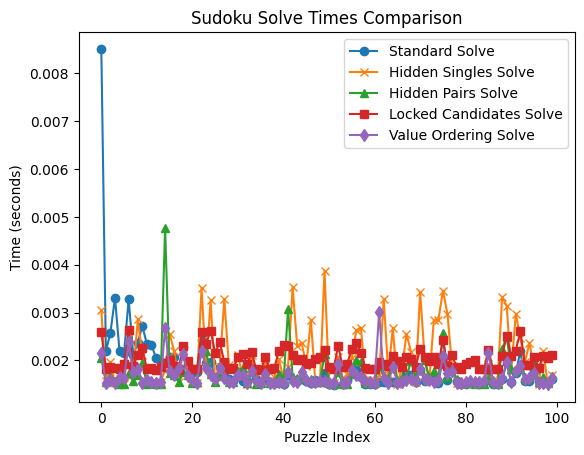

In [56]:
import matplotlib.pyplot as plt


def solve_all_times(grids, solve_function, name='', showif=None):
    """Attempt to solve a sequence of grids with the given solve function. Report results.
    Return list of solve times."""
    times = []  # 存储每个谜题的求解时间
    for grid in grids:
        start = time.perf_counter()
        values = solve_function(grid)  # 使用传入的求解函数
        t = time.perf_counter() - start
        times.append(t)  # 添加时间到列表
        if showif is not None and t > showif:
            display(grid_values(grid))
            if values: display(values)
            print('(%.2f seconds)\n' % t)
    return times

if __name__ == '__main__':
    grids = from_file("100sudoku.txt")  # 或其他你选择的数独集合
    times_standard = solve_all_times(grids, solve, "Standard Solve", None)
    times_hidden_singles = solve_all_times(grids, solveHiddenSingles, "Hidden Singles Solve", None)
    times_hidden_pairs = solve_all_times(grids, solve_Hidden_Pairs, "Hidden Pairs Solve", None)
    times_locked_candidates = solve_all_times(grids, solve_Locked_candidates, "Locked Candidates Solve", None)
    times_value_ordering = solve_all_times(grids, solve_value_ordering, "Value Ordering Solve", None)
    
    # 绘制求解时间的图像进行比较
    plt.plot(times_standard, marker='o', label='Standard Solve')
    plt.plot(times_hidden_singles, marker='x', label='Hidden Singles Solve')
    plt.plot(times_hidden_pairs, marker='^', label='Hidden Pairs Solve')
    plt.plot(times_locked_candidates, marker='s', label='Locked Candidates Solve')
    plt.plot(times_value_ordering, marker='d', label='Value Ordering Solve')
    plt.title('Sudoku Solve Times Comparison')
    plt.xlabel('Puzzle Index')
    plt.ylabel('Time (seconds)')
    plt.legend()
    plt.show()



Calculating average solve times: 100%|██████████| 100/100 [00:53<00:00,  1.88it/s]


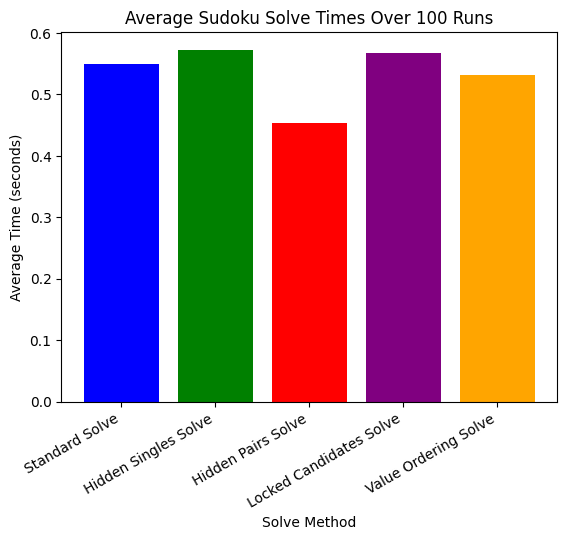

In [62]:
import matplotlib.pyplot as plt
import numpy as np  
from tqdm import tqdm  # 导入tqdm

def average_solve_times(grids, solve_function, iterations=100):
    """Run the solve function on a set of grids for a given number of iterations.
    Calculate the average solve time. Display progress with tqdm."""
    total_time = 0
    # 使用tqdm包裹外层循环，以展示总进度
    for _ in tqdm(range(iterations), desc="Calculating average solve times"):
        start = time.perf_counter()
        for grid in grids:
            solve_function(grid)  # 假设solve_function处理单个数独并返回结果
        total_time += time.perf_counter() - start
    average_time = total_time / iterations
    return average_time


if __name__ == '__main__':
    grids = from_file("top95.txt")  # 选取一个或几个数独进行测试
    avg_time_standard = average_solve_times(grids, solve)
    avg_time_hidden_singles = average_solve_times(grids, solveHiddenSingles)
    avg_time_hidden_pairs = average_solve_times(grids, solve_Hidden_Pairs)
    avg_time_locked_candidates = average_solve_times(grids, solve_Locked_candidates)
    avg_time_value_ordering = average_solve_times(grids, solve_value_ordering)
    
    # 绘制平均求解时间的条形图
    labels = ['Standard Solve', 'Hidden Singles Solve', 'Hidden Pairs Solve', 'Locked Candidates Solve', 'Value Ordering Solve']
    averages = [avg_time_standard, avg_time_hidden_singles, avg_time_hidden_pairs, avg_time_locked_candidates, avg_time_value_ordering]

    plt.bar(labels, averages, color=['blue', 'green','red','purple','orange'])
    plt.title('Average Sudoku Solve Times Over 100 Runs')
    plt.xlabel('Solve Method')
    plt.xticks(rotation=30, ha="right")  # 旋转45度并向右对齐
    plt.ylabel('Average Time (seconds)')
    plt.show()
